In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import os
import gc
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
_ = files.upload()

Saving NO2+Altitude.zip to NO2+Altitude.zip


In [3]:
!unzip NO2+Altitude.zip -d "NO2+Altitude"
from IPython.display import clear_output
clear_output(wait=False)
!rm NO2+Altitude.zip

In [4]:
files = pd.read_csv("/content/NO2+Altitude/NO2+Altitude/files.csv")

In [5]:
files

,Date,SatFile,GroundFile,AltGrid,Fold
0,2020-05-20,sat_2020-05-20.npy,g_2020-05-20.npy,alt_2020-05-20.npy,1
1,2021-04-27,sat_2021-04-27.npy,g_2021-04-27.npy,alt_2021-04-27.npy,2
2,2020-03-03,sat_2020-03-03.npy,g_2020-03-03.npy,alt_2020-03-03.npy,0
3,2020-10-10,sat_2020-10-10.npy,g_2020-10-10.npy,alt_2020-10-10.npy,2
4,2020-07-17,sat_2020-07-17.npy,g_2020-07-17.npy,alt_2020-07-17.npy,1
...,...,...,...,...,...
481,2020-07-25,sat_2020-07-25.npy,g_2020-07-25.npy,alt_2020-07-25.npy,3
482,2020-08-22,sat_2020-08-22.npy,g_2020-08-22.npy,alt_2020-08-22.npy,2
483,2020-03-23,sat_2020-03-23.npy,g_2020-03-23.npy,alt_2020-03-23.npy,3
484,2020-05-17,sat_2020-05-17.npy,g_2020-05-17.npy,alt_2020-05-17.npy,4


In [6]:
def pearson(y_true,y_pred):
  if len(y_true.shape)!=1:
    true = []
    for i in range(y_true.shape[0]):
      true.extend(y_true[i])
    pred = []
    for i in range(y_pred.shape[0]):
      pred.extend(y_pred[i])
  else:
    true=y_true
    pred=y_pred
  return np.mean((np.array(true)-np.mean(true))*(np.array(pred)-np.mean(pred)))/(np.std(np.array(true))*np.std(np.array(pred)))

def pearsonCorrAvgDays(true,pred):
  # assert len(true.shape)>=3,"true must have at least 3 dimensions, found {}".format(len(true.shape))
  assert true.shape==pred.shape, "true and pred must have same shape, found {} and {}".format(true.shape,pred.shape)
  scores = []
  for i in range(true.shape[0]):
    scores.append(pearson(true[i],pred[i]))
  return np.mean(scores),scores

def pearsonCorrAvgPixels(true,pred):
  scores = []
  for i in range(true.shape[1]):
    scores.append(pearson(true[:,i],pred[:,i]))
  return np.mean(scores),scores

In [15]:
def loadData(df,satdir = "/content/NO2+Altitude/NO2+Altitude/satellite/",gdir = "/content/NO2+Altitude/NO2+Altitude/ground/"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i])),axis=2)
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0),np.stack(Y,axis=0)

In [16]:
from sklearn.linear_model import LinearRegression

scores_list = []
rmses = []
maes = []
pearsons = []

for fold in range(5):
  print("\nFold {}\n".format(fold))
  train_files = files[files["Fold"]!=fold]
  val_files = files[files["Fold"]==fold]

  X_train,Y_train = loadData(train_files)
  X_val,Y_val = loadData(val_files)
  # loss_plt = utils.loss_plt()
  model = LinearRegression()
  model.fit(X_train.reshape(-1,1),Y_train.reshape(-1,1))

  #pred = model.predict(X_val.reshape(-1,1))
  pred = model.predict(X_val.reshape(-1, 1)).reshape(Y_val.shape)

  #print(Y_val.shape)
  #print(pred.shape)
  rmse = mean_squared_error(Y_val,pred,squared=False)
  mae = mean_absolute_error(Y_val,pred)
  rmses.append(rmse)
  maes.append(mae)

  print("Fold {} RMSE Score: {}".format(fold, rmse))
  print("Fold {} MAE Score: {}".format(fold, mae))

  s, ls = pearsonCorrAvgDays(Y_val, pred)
  print("Fold {} Pearson coeff avg over days: {}".format(fold, np.mean([i for i in ls if not pd.isnull(i)])))
  scores_list.append(ls)

print("\nCV RMSE Score: {}".format(np.mean(rmses)))
print("\nCV MAE Score: {}".format(np.mean(maes)))




Fold 0

Fold 0 RMSE Score: 7.566764529997447
Fold 0 MAE Score: 6.041530603666244
Fold 0 Pearson coeff avg over days: 0.08522754578219915

Fold 1

Fold 1 RMSE Score: 8.95324688280105
Fold 1 MAE Score: 6.776590367383814
Fold 1 Pearson coeff avg over days: 0.0757724577799903

Fold 2

Fold 2 RMSE Score: 8.227061893835826
Fold 2 MAE Score: 6.461740202381886
Fold 2 Pearson coeff avg over days: 0.06767917069439144

Fold 3

Fold 3 RMSE Score: 7.627537200244522
Fold 3 MAE Score: 5.919761396639667
Fold 3 Pearson coeff avg over days: 0.08651048221729893

Fold 4

Fold 4 RMSE Score: 7.653754693783153
Fold 4 MAE Score: 6.156511443989171
Fold 4 Pearson coeff avg over days: 0.08796809601647612

CV RMSE Score: 8.005673040132399

CV MAE Score: 6.271226802812157


In [20]:
print(Y_val.shape)
inp = X_val[10][:,:,0]
pred = pred[10].reshape((49,67))
true = Y_val[10].reshape((X_train[0].shape[0],X_train[0].shape[1]))

(65, 3283)


In [22]:
import numpy as np
import folium
import branca.colormap as cm

ireland_bound = [-9.4003, -6.032, 51.828500000000005, 54.323]
llcrn, urcrn = (-9.4003, 51.8285), (-6.032, 54.323)

# Create latitude and longitude grids
num_cols = int((urcrn[0] - llcrn[0]) // 0.05)
num_rows = int((urcrn[1] - llcrn[1]) // 0.05)
lat_coords = np.linspace(llcrn[1], urcrn[1], num_rows+1)
lon_coords = np.linspace(llcrn[0], urcrn[0], num_cols+1)
lat,lon = np.meshgrid(lon_coords, lat_coords)

pred = np.array(pred).astype(np.float64)
# Initialize a map
m = folium.Map(location=[53.0, -7.5], zoom_start=7, tiles='Stamen Terrain')

# Convert the numpy array to a GeoJSON-like structure
features = []
for i in range(num_rows):
    for j in range(num_cols):
        polygon = [
            [lat[i, j], lon[i, j]],
            [lat[i+1, j], lon[i+1, j]],
            [lat[i+1, j+1], lon[i+1, j+1]],
            [lat[i, j+1], lon[i, j+1]],
            [lat[i, j], lon[i, j]]
        ]
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Polygon',
                'coordinates': [polygon]
            },
            'properties': {
                'value': true[i, j]  # Use the corresponding value from the 'pred' aklnxrray
            }
        }
        features.append(feature)

# Define a color scale for the 'pred' values
vmin = np.min(true)
vmax = np.max(true)
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'orange', 'red'], vmin=vmin, vmax=vmax)

# Add the GeoJSON layer to the map and set fill color based on 'pred' values
folium.GeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['value']),
        'color': 'none',
        'fillOpacity': 0.6
    }
).add_to(m)


# Create a color bar legend with values
legend_html = '''
    <div style="
        position: fixed;
        bottom: 360px; left: 520px; width: 70px; height: 134px;
        background-color: white;
        z-index: 9999; font-size: 12px;
        border: 2px solid grey; padding: 2px;
    ">

'''

num_values = 5  # Number of values to display in the color bar legend
value_range = np.linspace(vmin, vmax, num_values)

for value in value_range:
    color = colormap(value)
    label = f'{int(value)}'  # Format the value as desired
    legend_html += f'<p><span style="background-color:{color};">&nbsp;&nbsp;&nbsp;&nbsp;</span> {label}</p>'

legend_html += '</div>'

# Add the color bar legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Crop the map to the bounds of the selected region
#m.fit_bounds([[llcrn[1], llcrn[0]], [urcrn[1], urcrn[0]]])
#m.fit_bounds(bounds)

# Save and display the map
m.save('map.html')

m

In [24]:
import numpy as np
import folium
import branca.colormap as cm

ireland_bound = [-9.4003, -6.032, 51.828500000000005, 54.323]
llcrn, urcrn = (-9.4003, 51.8285), (-6.032, 54.323)

# Create latitude and longitude grids
num_cols = int((urcrn[0] - llcrn[0]) // 0.05)
num_rows = int((urcrn[1] - llcrn[1]) // 0.05)
lat_coords = np.linspace(llcrn[1], urcrn[1], num_rows+1)
lon_coords = np.linspace(llcrn[0], urcrn[0], num_cols+1)
lat,lon = np.meshgrid(lon_coords, lat_coords)

pred = np.array(pred).astype(np.float64)
# Initialize a map
m = folium.Map(location=[53.0, -7.5], zoom_start=7, tiles='Stamen Terrain')

# Convert the numpy array to a GeoJSON-like structure
features = []
for i in range(num_rows):
    for j in range(num_cols):
        polygon = [
            [lat[i, j], lon[i, j]],
            [lat[i+1, j], lon[i+1, j]],
            [lat[i+1, j+1], lon[i+1, j+1]],
            [lat[i, j+1], lon[i, j+1]],
            [lat[i, j], lon[i, j]]
        ]
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Polygon',
                'coordinates': [polygon]
            },
            'properties': {
                'value': pred[i, j]  # Use the corresponding value from the 'pred' aklnxrray
            }
        }
        features.append(feature)

# Define a color scale for the 'pred' values
vmin = np.min(pred)
vmax = np.max(pred)
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'orange', 'red'], vmin=vmin, vmax=vmax)

# Add the GeoJSON layer to the map and set fill color based on 'pred' values
folium.GeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['value']),
        'color': 'none',
        'fillOpacity': 0.6
    }
).add_to(m)


# Create a color bar legend with values
legend_html = '''
    <div style="
        position: fixed;
        bottom: 360px; left: 1120px; width: 70px; height: 134px;
        background-color: white;
        z-index: 9999; font-size: 12px;
        border: 2px solid grey; padding: 2px;
    ">

'''

num_values = 5  # Number of values to display in the color bar legend
value_range = np.linspace(vmin, vmax, num_values)

for value in value_range:
    color = colormap(value)
    label = f'{int(value)}'  # Format the value as desired
    legend_html += f'<p><span style="background-color:{color};">&nbsp;&nbsp;&nbsp;&nbsp;</span> {label}</p>'

legend_html += '</div>'

# Add the color bar legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Crop the map to the bounds of the selected region
#m.fit_bounds([[llcrn[1], llcrn[0]], [urcrn[1], urcrn[0]]])
#m.fit_bounds(bounds)

# Save and display the map
m.save('map.html')

m


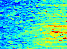

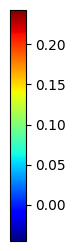

In [ ]:
import numpy as np
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from PIL import Image
from folium.plugins import FloatImage

ireland_bound = [-9.4003, -6.032, 51.828500000000005, 54.323]
llcrn, urcrn = (-9.4003, 51.8285), (-6.032, 54.323)

# Create latitude and longitude grids
num_cols = int((urcrn[0] - llcrn[0]) // 0.05)
num_rows = int((urcrn[1] - llcrn[1]) // 0.05)
lat_coords = np.linspace(llcrn[1], urcrn[1] + 0.05, num_rows)
lon_coords = np.linspace(llcrn[0], urcrn[0] + 0.05, num_cols)
lon, lat = np.meshgrid(lon_coords, lat_coords)

# Create the Folium map centered around Ireland
m = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=6, tiles='Stamen Terrain')

# Plot the data on the map
# true = np.array()

# Normalize the data values to range from 0 to 1
norm = colors.Normalize(vmin=inp.min(), vmax=inp.max())
colormap = cm.jet(norm(inp))

# Modify the alpha channel to make the overlay transparent
colormap[:, :, 3] = 0.6  # Set the alpha value (0.0 - fully transparent, 1.0 - fully opaque)

# Create a colorbar legend
fig, ax = plt.subplots(figsize=(0.2, 3))
colorbar = cm.ScalarMappable(norm=norm, cmap=cm.jet)
colorbar.set_array([inp])
plt.colorbar(colorbar, cax=ax)

# Save the colorbar as an image
colorbar_image_path = "colorbar.png"
plt.savefig(colorbar_image_path, bbox_inches="tight", pad_inches=0, transparent=True)

# Add the colorbar overlay to the map
colorbar_image = Image.open(colorbar_image_path)
FloatImage(colorbar_image, bottom=20, left=65).add_to(m)

folium.raster_layers.ImageOverlay(
    image=colormap,
    bounds=[[lat.min(), lon.min()], [lat.max(), lon.max()]],
).add_to(m)

# Display the map

map_path = "map.html"
m.save(map_path)
m


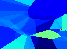

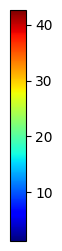

In [ ]:
import numpy as np
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from PIL import Image
from folium.plugins import FloatImage

ireland_bound = [-9.4003, -6.032, 51.828500000000005, 54.323]
llcrn, urcrn = (-9.4003, 51.8285), (-6.032, 54.323)

# Create latitude and longitude grids
num_cols = int((urcrn[0] - llcrn[0]) // 0.05)
num_rows = int((urcrn[1] - llcrn[1]) // 0.05)
lat_coords = np.linspace(llcrn[1], urcrn[1] + 0.05, num_rows)
lon_coords = np.linspace(llcrn[0], urcrn[0] + 0.05, num_cols)
lon, lat = np.meshgrid(lon_coords, lat_coords)

# Create the Folium map centered around Ireland
m = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=6, tiles='Stamen Terrain')

# Plot the data on the map
# true = np.array()

# Normalize the data values to range from 0 to 1
norm = colors.Normalize(vmin=pred.min(), vmax=pred.max())
colormap = cm.jet(norm(pred))

# Modify the alpha channel to make the overlay transparent
colormap[:, :, 3] = 0.6  # Set the alpha value (0.0 - fully transparent, 1.0 - fully opaque)

# Create a colorbar legend
fig, ax = plt.subplots(figsize=(0.2, 3))
colorbar = cm.ScalarMappable(norm=norm, cmap=cm.jet)
colorbar.set_array([pred])
plt.colorbar(colorbar, cax=ax)

# Save the colorbar as an image
colorbar_image_path = "colorbar1.png"
plt.savefig(colorbar_image_path, bbox_inches="tight", pad_inches=0, transparent=True)

# Add the colorbar overlay to the map
colorbar_image = Image.open(colorbar_image_path)
FloatImage(colorbar_image, bottom=20, left=65).add_to(m)

folium.raster_layers.ImageOverlay(
    image=colormap,
    bounds=[[lat.min(), lon.min()], [lat.max(), lon.max()]],
).add_to(m)

# Display the map

map_path = "map1.html"
m.save(map_path)
m



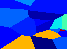

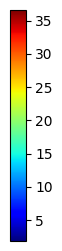

In [ ]:
import numpy as np
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from PIL import Image
from folium.plugins import FloatImage

ireland_bound = [-9.4003, -6.032, 51.828500000000005, 54.323]
llcrn, urcrn = (-9.4003, 51.8285), (-6.032, 54.323)

# Create latitude and longitude grids
num_cols = int((urcrn[0] - llcrn[0]) // 0.05)
num_rows = int((urcrn[1] - llcrn[1]) // 0.05)
lat_coords = np.linspace(llcrn[1], urcrn[1] + 0.05, num_rows)
lon_coords = np.linspace(llcrn[0], urcrn[0] + 0.05, num_cols)
lon, lat = np.meshgrid(lon_coords, lat_coords)

# Create the Folium map centered around Ireland
m = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=6, tiles='Stamen Terrain')

# Plot the data on the map
# true = np.array()

# Normalize the data values to range from 0 to 1
norm = colors.Normalize(vmin=true.min(), vmax=true.max())
colormap = cm.jet(norm(true))

# Modify the alpha channel to make the overlay transparent
colormap[:, :, 3] = 0.6  # Set the alpha value (0.0 - fully transparent, 1.0 - fully opaque)

# Create a colorbar legend
fig, ax = plt.subplots(figsize=(0.2, 3))
colorbar = cm.ScalarMappable(norm=norm, cmap=cm.jet)
colorbar.set_array([true])
plt.colorbar(colorbar, cax=ax)

# Save the colorbar as an image
colorbar_image_path = "colorbar1.png"
plt.savefig(colorbar_image_path, bbox_inches="tight", pad_inches=0, transparent=True)

# Add the colorbar overlay to the map
colorbar_image = Image.open(colorbar_image_path)
FloatImage(colorbar_image, bottom=20, left=65).add_to(m)

folium.raster_layers.ImageOverlay(
    image=colormap,
    bounds=[[lat.min(), lon.min()], [lat.max(), lon.max()]],
).add_to(m)

# Display the map

map_path = "map1.html"
m.save(map_path)
m